# **Desenvolvimento dos modelos**

## **Importando Libs**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub
import os

## **Recebendo dataset**

In [ ]:
#----------------- Carregando dataset -------------------------------------#
path = kagglehub.dataset_download("uom190346a/sleep-health-and-lifestyle-dataset")

def load_dataset(dataset_dir_path):
    csv_file_name = "Sleep_health_and_lifestyle_dataset.csv"
    full_csv_path = os.path.join(dataset_dir_path, csv_file_name)
    df = pd.read_csv(full_csv_path)
    return df

df_origin = load_dataset(path)

#----------------- Tratamento Inicial -------------------------------------#
def dividir_pressao(dataset):
    dataset[['Systolic', 'Diastolic']] = (
    dataset['Blood Pressure']
    .str.split('/', expand=True)
    .astype(float)
    )
    return dataset

def converter_NaN_Sleep_disorder(dataset):
  dataset['Sleep Disorder'] = dataset['Sleep Disorder'].fillna('No Disorder')
  return dataset

def ajuste_inical(dataset):
  dataset =  dividir_pressao(dataset)
  dataset = dataset.drop(columns=['Blood Pressure'])
  dataset = converter_NaN_Sleep_disorder(dataset)
  return dataset

df = ajuste_inical(df_origin)

#----------------- Tratando duplicatas -------------------------------------#
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')

#----------------- Econding -------------------------------------#

# Atributo BMI Category
BMI_mapping = {
    'Normal': 0,
    'Overweight': 1,
    'Obese': 2,
}

df['BMI Category'] = df['BMI Category'].map(BMI_mapping)

# Atributo Gender
df = pd.get_dummies(df, columns=['Gender'], dtype=int)

# Atributo Sleep Disorder
Disorder_mapping = {
    'No Disorder': 0,
    'Sleep Apnea': 1,
    'Insomnia': 2,
}
df['Sleep Disorder'] = df['Sleep Disorder'].map(Disorder_mapping)

# Atributo Occupation
contagem = df['Occupation'].value_counts()

profissoes_raras = contagem[contagem <= 4].index
df['Occupation'] = df['Occupation'].replace(profissoes_raras, 'Other')
df = pd.get_dummies(df, columns=['Occupation'], prefix='Occ', dtype=int)

#----------------- Dropando Freatures -------------------------------------#
df = df.drop(columns=['Person ID', 'Daily Steps', 'Quality of Sleep'])

#----------------- Divisão -------------------------------------#
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
#----------------- Salvando os valores de média e desvio -----------------
numeric_cols = ['Age', 'Sleep Duration',
                'Physical Activity Level', 'Stress Level',
                'Systolic', 'Diastolic', 'Heart Rate',
                ]
# Esses valores são muito importantes, pois eles serão usados do formulário para normalizar as colunas numéricas
parametros_clinicos = {}
for col in numeric_cols:
    parametros_clinicos[col] = {
        'mean': X_train[col].mean(),
        'std': X_train[col].std()
    }
print(parametros_clinicos)

#-----------------Normalização-------------------------------------#


X_train_norm = X_train.copy()
X_train_norm[numeric_cols] = (X_train[numeric_cols] - X_train[numeric_cols].mean()) / X_train[numeric_cols].std()

X_test_norm = X_test.copy()
X_test_norm[numeric_cols] = (X_test[numeric_cols] - X_train[numeric_cols].mean()) / X_train[numeric_cols].std()

X_train = X_train_norm.copy()
X_test = X_test_norm.copy()



100%|██████████| 2.54k/2.54k [00:00<00:00, 4.50MB/s]

Extracting files...


{'Age': {'mean': np.float64(41.862876254180605), 'std': 8.585804173759081}, 'Sleep Duration': {'mean': np.float64(7.122742474916388), 'std': 0.7967327391411487}, 'Physical Activity Level': {'mean': np.float64(59.13377926421405), 'std': 21.07772837987556}, 'Stress Level': {'mean': np.float64(5.4280936454849495), 'std': 1.779076765868213}, 'Systolic': {'mean': np.float64(128.57859531772576), 'std': 7.805286242173309}, 'Diastolic': {'mean': np.float64(84.67892976588628), 'std': 6.149474047877638}, 'Heart Rate': {'mean': np.float64(70.26086956521739), 'std': 4.295952587877578}}


Este notebook foca no desenvolvimento e validação dos modelos. Para detalhes sobre a Análise Exploratória de Dados (EDA) e as decisões de pré-processamento, consulte o **[notebook de EDA](https://colab.research.google.com/drive/1HDcvgthcB4ooSTJvoMyNNtQvkwy_t6rh?usp=sharing#scrollTo=ZK_mXrrEPLh7)** linkado.

**Descrição das variáveis de dados**

- `X_train`: Features para treino
- `y_train`: Targets para treino
- `X_test`: Features para teste
- `y_test`: Targets para teste

## **Baseline: Classe majoritária**

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Baseline mínimo
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
baseline_pred = dummy_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, baseline_pred)

print(f"Acurácia do Baseline mínimo: {baseline_acc:.2%}")

Acurácia do Baseline mínimo: 58.67%


Pela estratégia de classe majoritária, estabelecemos um 'chute qualificado' prevendo sempre a classe de maior frequência ('No Disorder').

Qualquer modelo complexo só será considerado válido se apresentar desempenho significativamente superior à `Acurácia do Baseline mínimo`, garantindo que o algoritmo aprendeu padrões clínicos reais e não apenas a distribuição dos dados.

## **Primeira abordagem: Modelagem Linear com Regressão Logística**

**Regressão Logística** é um modelo de aprendizado supervisionado utilizado para **classificação**, podendo ser binária ou multiclasse. No caso multiclasse, o modelo utiliza a **função Softmax**, que generaliza a função sigmoide ao transformar a combinação linear das variáveis de entrada em uma distribuição de probabilidades sobre todas as classes possíveis, cuja soma é igual a 1. A classe prevista é aquela com maior probabilidade estimada pelo modelo.

Antes de aplicar algoritmos complexos, é boa prática iniciar com um modelo linear robusto e interpretável. Utilizamos a Regressão Logística (com solver 'lbfgs') para testar se os dados são linearmente separáveis.

Caso a performance seja alta, o problema é linearmente simples, do contrário, isso justificará matematicamente a necessidade de avanço para modelos não-lineares mais robustos.

In [ ]:
from sklearn.linear_model import LogisticRegression

softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs', C= 0.15)
softmax.fit(X_train, y_train) # Treinando o modelo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.15, multi_class='multinomial')

In [ ]:
from sklearn.metrics import classification_report

y_pred = softmax.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        44
           1       0.78      0.88      0.82        16
           2       1.00      0.87      0.93        15

    accuracy                           0.89        75
   macro avg       0.90      0.88      0.89        75
weighted avg       0.90      0.89      0.89        75



A métrica mais relevante para a avaliação de modelos de **classificação** é o **F1-score.**

O **F1-score** é uma métrica de avaliação que combina **precisão** e **recall** em uma única medida por meio da **média harmônica**, sendo especialmente adequada para cenários com possível desbalanceamento entre classes. Em aplicações de caráter clínico, recomenda-se um F1-score **igual ou superior a 0,80.**

As classes 0 e 2 apresentam F1-scores de **0,91** e **0,93**, respectivamente, enquanto a classe 1 possui um desempenho significativamente inferior, com **0,82**. Esse resultado pode ser explicado pela **sobreposição dos valores das features** da classe 1 com as demais classes. Como o modelo baseado em **Softmax** assume relações **lineares** para realizar a separação entre classes, essa sobreposição dificulta a distinção adequada, o que se reflete, como evidência adicional, na **baixa precisão observada para a classe 1.**

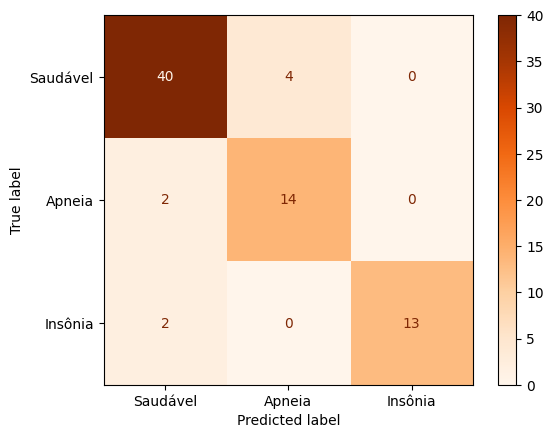

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Saudável', 'Apneia', 'Insônia']).plot(cmap='Oranges')

A **matriz de confusão** é um artifício essencial para visualizar o comportamento de modelos de **classificação**. Nela, as **colunas representam os valores inferidos (preditos)** pelo modelo, enquanto as **linhas correspondem aos valores verdadeiros.**

## **Evolução: Modelagem Não-Linear com Random Forest**

**Random Forest** é um modelo de aprendizado supervisionado baseado em **conjuntos de árvores de decisão**, no qual cada árvore é treinada a partir de amostras aleatórias dos dados e de subconjuntos das *features*. A predição final é obtida por meio de **votação majoritária (classificação)**, o que reduz variância e o risco de *overfitting* das árvores.

O Random Forest foi adotado como o **novo modelo** pela capacidade de superar limitações intrínsecas da **linearidade**. Diferente da Regressão Logística, tal algoritmo mapeia **fronteiras de decisão não-lineares** e captura interações complexas entre variáveis, garantindo maior **robustez a ruído, outliers e sobreposição entre classes.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    min_samples_leaf=5,
    random_state=42,
)

In [ ]:
rf_final.fit(X_train, y_train)

y_pred_rf = rf_final.predict(X_test)
print("--- RELATÓRIO RANDOM FOREST ---")
print(classification_report(y_test, y_pred_rf))

--- RELATÓRIO RANDOM FOREST ---
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        44
           1       0.93      0.88      0.90        16
           2       1.00      0.87      0.93        15

    accuracy                           0.93        75
   macro avg       0.95      0.91      0.93        75
weighted avg       0.94      0.93      0.93        75



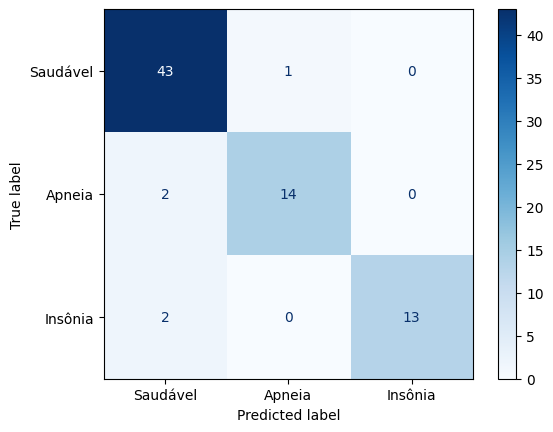

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=['Saudável', 'Apneia', 'Insônia']).plot(cmap='Blues')

Ao comparar os modelos, observa-se que o **Random Forest** apresenta um desempenho claramente superior à **Regressão Logística com Softmax**, motivo pelo qual foi escolhido como modelo final. O modelo alcançou **93% de acurácia e um F1-score macro de 0,93,** indicando um bom equilíbrio entre precisão e recall entre as classes.

Enquanto o modelo linear anterior apresentou dificuldades principalmente na classe 1, devido à sobreposição dos valores das features, o Random Forest conseguiu lidar melhor com esse cenário. Isso ocorre porque o modelo é capaz de capturar relações não lineares e interações mais complexas nos dados, resultando em melhorias consistentes nas métricas de desempenho.

Assim, os resultados obtidos reforçam que o Random Forest se ajusta melhor ao problema proposto, superando as limitações do modelo anterior e justificando sua adoção como modelo final.

### **Overfitting Check**

In [ ]:
# Comparação entre acurácia de treino e de teste

acc_train = rf_final.score(X_train, y_train)
acc_test = rf_final.score(X_test, y_test)

print(f"Acurácia no TREINO: {acc_train:.2%}")
print(f"Acurácia no TESTE:  {acc_test:.2%}")

if (acc_train - acc_test) < 0.10:
    print(">> O modelo apresentou baixo Overfitting.")
else:
    print(">> O modelo apresentou indícios de Overfitting.")

Acurácia no TREINO: 91.97%
Acurácia no TESTE:  93.33%
>> O modelo apresentou baixo Overfitting.


Observou-se um fenômeno de generalização robusta, onde a acurácia de teste (93.33%) superou ligeiramente a de treino (91.97%).

Isso indica que as técnicas de regularização aplicadas e o pré-processamento foram eficazes em prevenir o overfitting, criando um modelo conservador e altamente adaptável a novos dados.

### **Features mais importantes para o Random Forest**

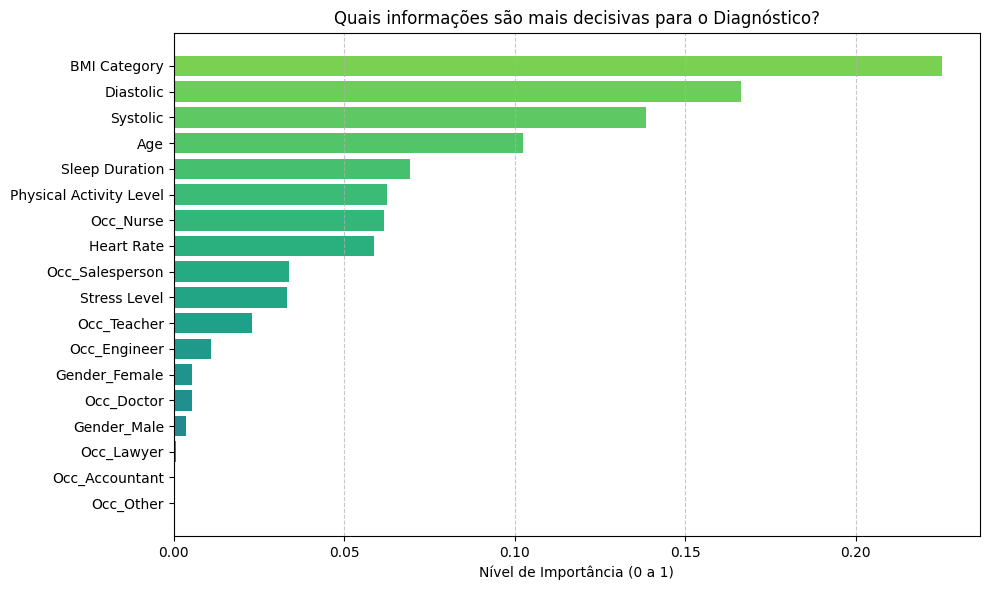

In [ ]:
importances = rf_final.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Atributo': feature_names, 'Importância': importances})

# 2. Ordenar para o gráfico
feature_importance_df = feature_importance_df.sort_values(by='Importância', ascending=True)

# 3. Plotar
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.4, 0.8, len(feature_importance_df)))
plt.barh(feature_importance_df['Atributo'], feature_importance_df['Importância'], color=colors)
plt.xlabel('Nível de Importância (0 a 1)')
plt.title('Quais informações são mais decisivas para o Diagnóstico?')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

A análise de importância de atributos valida a coerência fisiológica do modelo. O fato de o IMC e a Pressão Arterial serem os preditores dominantes (respondendo por quase 50% da decisão) alinha o algoritmo com a literatura médica sobre Apneia do Sono, aumentando a confiabilidade da ferramenta para uso clínico como suporte à triagem.

## **Visualização do Ganho de Perfomance**

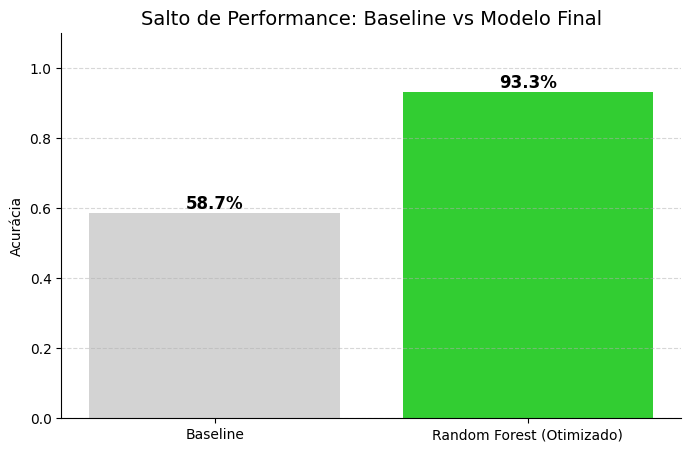

In [ ]:
# Dados para o gráfico
modelos = ['Baseline', 'Random Forest (Otimizado)']
acuracias = [baseline_acc, acc_test]

# Criando o gráfico
plt.figure(figsize=(8, 5))
barras = plt.bar(modelos, acuracias, color=['#d3d3d3', '#32CD32'])

for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura,
             f'{altura:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Salto de Performance: Baseline vs Modelo Final', fontsize=14)
plt.ylabel('Acurácia')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Para quantificar o impacto da modelagem inteligente, comparamos visualmente o desempenho do nosso Modelo Final (Random Forest) contra o Baseline.

O gráfico ilustra o salto de qualidade (lift). Enquanto o chute estatístico nos deixaria estagnados em ~59%, a implementação do Random Forest Otimizado elevou a acurácia para ~93%.

Essa diferença visual comprova que o modelo foi capaz de capturar relações complexas entre os sinais vitais e os distúrbios do sono, entregando valor real para a triagem clínica.

## **Exportando modelo e métricas para normalização**

In [ ]:
import joblib as jb

#Salvando modelo final
jb.dump(rf_final, 'modelo_sono_rf.pkl')

#Salvando métricas

metricas = {
    'norm': parametros_clinicos,
    'numeric_cols': numeric_cols,
    'columns_order': X_train.columns.tolist()
}

jb.dump(metricas, 'metricas_normalizacao.pkl')


['metricas_normalizacao.pkl']

Os modelos são baixados na pasta `/content`

O próximo Colab é o de **[Inferência](https://colab.research.google.com/drive/1eSu_BYy89-GnoMUBzBcXp51ZIUPj8c8n?usp=sharing)**